# <center> meta-rMERA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
from jax.config import config

config.update("jax_enable_x64", True)
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## energy
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [10]:
# j=1, Bx=1
def energy(c: tc.Circuit, j: float = 1.0, hx: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e -= hx * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n-1):  
        e += j * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i+1])
        )  # <Z_i Z_{i+1}>
    return tc.backend.real(e)

## meta-rMERA net

In [9]:
def MERA(params, n, hx):
    params = tc.backend.cast(params, "complex128")
    hx = tc.backend.cast(hx, "complex128")
    c = tc.Circuit(n)
    
    idx = 0
    
    # encoding layer
    for i in range(n):
        c.rx(i, theta=(params[4*i] * hx + params[4*i+1]))
        c.rz(i, theta=(params[4*i+2] * hx + params[4*i+1+3]))
    idx += 4*n
    
    for i in range(0, n-1, 2):
        c.cnot(i, i+1)
    
    for i in range(n):
        c.rx(i, theta=params[2*i])
        c.rz(i, theta=params[2*i+1])
    idx += 2*n
    
    
    # processing layer
    for n_layer in range(1, int(np.log2(n))+1):
        n_qubit = 2**n_layer   # 参与计算的qubit数
        step = int(n / n_qubit)

        # even    
        for i in range(step, n-step, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        # odd   
        for i in range(0, n, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx+1])
            idx += 2
        
        # c.barrier()

    # measure
    #e = energy(c, hx=hx)
    return c, idx
    #return e

98


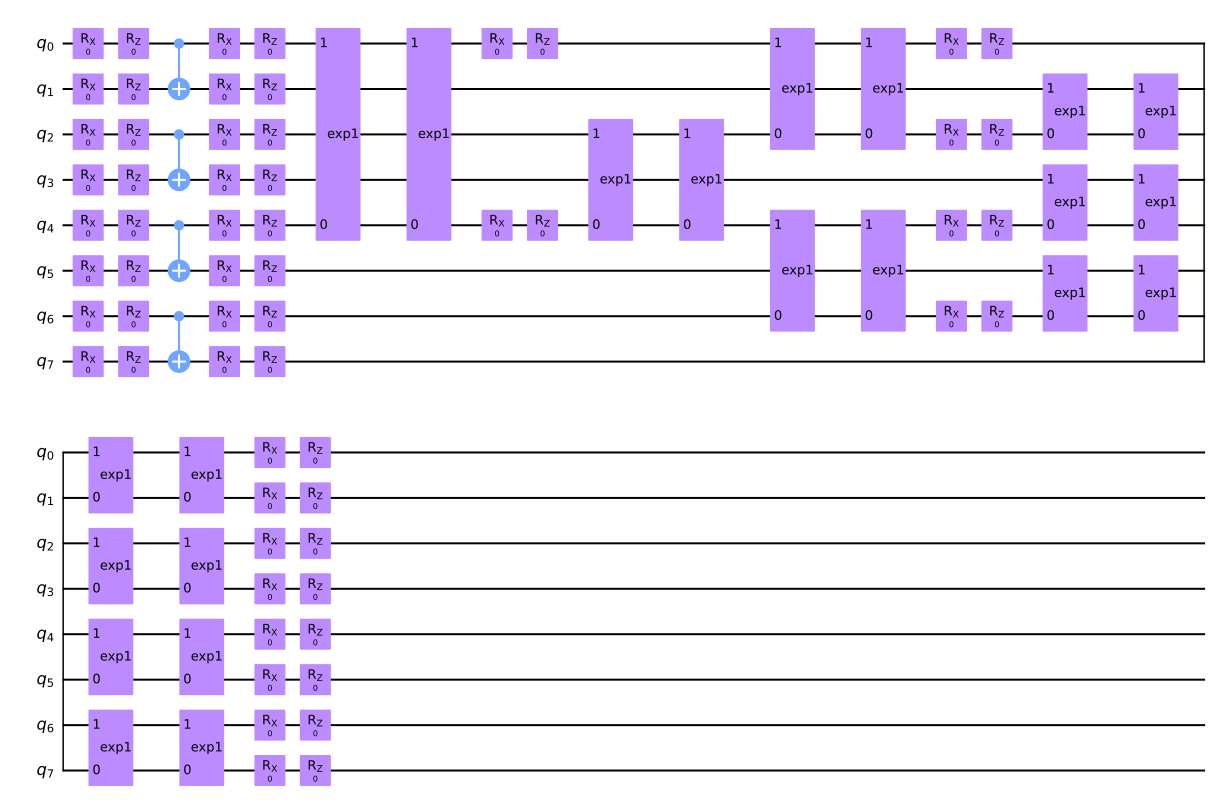

In [4]:
cirq, idx = MERA(np.zeros(1000), 8, 1)
print(idx)
cirq.draw()

In [6]:
def meta_MERA(params, n, hx):
    e_all = tf.zeros([1], dtype=tf.float64)
    for h in hx:
        e_all += MERA(params, n, h)
        
    return e_all

## train

In [7]:
meta_MERA_tfim_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(meta_MERA)
)

def batched_train(n, hx, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    best_params = None
    for i in range(maxiter):
        e, grad = meta_MERA_tfim_vvag(params, n, hx)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e)<lowest_energy:
            lowest_energy = tf.reduce_min(e)
            best_params = params[tf.argmin(e).numpy()[0]]
        if i % 200 == 0:
            print(e)
    return lowest_energy, best_params

In [8]:
n = 8
hx = tf.random.uniform(
    shape=[10], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
with tf.device('/cpu:0'):
    energy, best_params = batched_train(n, hx, batch=5, maxiter=3000, lr=0.007)

tf.Tensor(
[[-4.37849485]
 [ 4.01522117]
 [ 3.38725918]
 [ 1.10253036]
 [ 2.63466935]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-94.12486036]
 [-91.68097092]
 [-88.64535849]
 [-86.21221776]
 [-87.60782907]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-96.44707701]
 [-94.29871529]
 [-94.58318281]
 [-95.4623213 ]
 [-94.89081276]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-97.17723066]
 [-97.07097331]
 [-96.70513323]
 [-97.28120932]
 [-97.10373638]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-97.49126906]
 [-98.20226732]
 [-98.3766112 ]
 [-97.65113008]
 [-97.71919761]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-97.92159206]
 [-98.44462335]
 [-98.60417803]
 [-97.80214707]
 [-98.22650393]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-98.22438299]
 [-98.52485635]
 [-98.72247532]
 [-97.91065174]
 [-98.63018746]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-98.53224811]
 [-98.5678435 ]
 [-98.8455067 ]
 [-97.98346263]
 [-98.75848358]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-98.73100349]
 [

## compare

In [11]:
# Creating test data
from tqdm.notebook import tqdm
test_hx = tf.random.uniform(
    shape=[100], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
test_energies = tf.zeros_like(test_hx).numpy()

for i, h in tqdm(enumerate(test_hx)):
    c, idx = MERA(best_params, n, h)
    test_energies[i] = energy(c, hx=tc.backend.cast(h, "complex128")).numpy()
    
exact_energies = [-8, -8.02, -8.0802, -8.18105, -8.32335, -8.50835, -8.7379, -9.01465, -9.3425, -9.728, -10.1859, -10.7429, -11.35695, -12.0066, -12.6815, -13.3754, -14.08405]

0it [00:00, ?it/s]

In [12]:
import quimb
DMRG_energies = []
for i in np.linspace(0,1.6,17):
    h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=1.0, bx=i, S=1, cyclic=False)  # Ising Hamiltonian in MPO form (number, zz interaction strenth, x-magnetic field strenth)
    dmrg = quimb.tensor.tensor_dmrg.DMRG(h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13)
    dmrg.solve(tol=1e-9, verbosity=0)
    DMRG_energies.append(dmrg.energy)

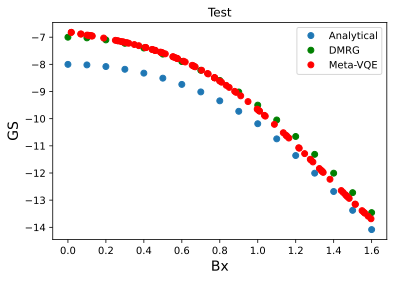

In [13]:
plt.plot(np.linspace(0,1.6,17), exact_energies, 'o', label='Analytical')
plt.plot(np.linspace(0,1.6,17), DMRG_energies, 'go', label='DMRG')
plt.plot(test_hx, test_energies, 'ro', label='Meta-VQE')
plt.title("Test")
plt.xlabel("Bx", fontsize=14)
plt.ylabel("GS", fontsize=14)
plt.legend()
plt.show()

In [14]:
energy, best_params

(<function __main__.energy(c: tensorcircuit.circuit.Circuit, j: float = 1.0, hx: float = 1.0)>,
 <tf.Tensor: shape=(98,), dtype=float64, numpy=
 array([-7.23958638e-01, -1.28410970e+00, -9.55779390e-01, -1.05875686e+00,
         1.64889634e-01,  2.69838805e-01,  3.60794667e-01,  1.23791713e+00,
        -9.08108677e-01,  1.83802251e-01,  2.02728902e-01,  3.70272648e-01,
        -7.35841079e-01, -3.54346961e+00, -4.37296967e-01,  3.01458515e+00,
        -4.28069401e-01,  1.81405391e-02,  1.25754549e-01,  1.28670533e+00,
         1.09534895e+00, -7.29916216e-02,  2.68995165e-01, -7.17995655e-01,
        -5.58415799e-01, -7.14590318e-01, -4.72199908e-01,  1.71059359e-01,
        -6.66466824e-01,  1.49360694e+00,  1.16794552e-01,  1.67962687e+00,
        -4.70059521e+00, -1.14980225e+00, -3.40742054e+00,  2.78114379e-01,
        -1.69623549e-01,  4.74022555e-01, -3.30097749e-01,  1.20971833e+00,
        -4.82687197e-01, -1.01697142e+00, -8.67866819e-01,  8.91037508e-01,
        -1.07301571e

In [15]:
test_hx, test_energies

(<tf.Tensor: shape=(100,), dtype=float64, numpy=
 array([0.77275316, 0.49269931, 0.06720249, 1.55799587, 1.16394968,
        0.127908  , 0.49940793, 0.80909934, 0.24987508, 0.57113105,
        1.34483899, 0.40675543, 0.60867722, 0.27949413, 1.28053438,
        0.44572496, 0.77175138, 0.44307803, 0.77279834, 0.99707298,
        0.41049445, 0.18828979, 0.73520503, 1.24709336, 0.77314186,
        0.3207088 , 1.3409833 , 0.55272104, 1.4622083 , 0.99945723,
        1.00721907, 0.12091519, 0.48701832, 0.61801024, 0.34963614,
        1.03971931, 0.55458573, 0.56307709, 0.26035938, 1.14824391,
        1.38056359, 1.51438761, 0.4612762 , 0.12661004, 0.06950108,
        1.47356517, 0.31241981, 0.10789251, 0.45884982, 0.51304341,
        0.79921028, 0.94878215, 0.70440948, 1.13468995, 0.66340903,
        0.10084142, 0.0175514 , 0.91030875, 0.490416  , 0.45713377,
        1.54953028, 0.73911068, 0.57810572, 0.11646696, 0.67054198,
        1.15397861, 0.29078603, 1.0097847 , 1.58149674, 1.3367382 ,